## Importiere `pandas`, `matplotlib`

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import json
from datetime import datetime as dt
import locale
from scipy.interpolate import interp1d
from configparser import ConfigParser
from functions import *

## Lade die Konfigurationen aus `config.ini`
#### Definiere die Umgebung

In [15]:
config = ConfigParser()
files = config.read('config.ini')

# Wechsel des plt.style per config.ini machbar.
plt.style.use(config.get('theme', 'plt.style'))

# Damit Daten mit den deutschen Begriffen für die Monat generiert werden.
locale = locale.setlocale(locale.LC_TIME, "de_DE")

In [16]:
env = 'final'
database_file = config.get(env, 'database_file')
date_begin = config.get(env, 'date_begin')
date_end = config.get(env, 'date_end')
dpi = config.get(env, 'dpi')

In [17]:
df = pd.read_json(database_file)

#### Filter die Artikel nach: Sind zwischen dem und dem Datum veröffentlich worden.

In [18]:
df = df.loc[(df['date'] >= date_begin) & (df['date'] <= date_end)]

In [19]:
df['date'] = pd.to_datetime(df['date'], utc=True)

#### Fülle alle NaN Werte aus `rankings` mit einem leeren Array

In [20]:
df['rankings'] = df['rankings'].fillna("[]")

#### Füge ein neues Feature hinzu: Themengebiet

In [21]:
topics = json.loads(open("topics/topics.json", "r").read())

df['tags_full'] = ['; '.join(tags) for tags in df['tags'].to_list()]

for topic in topics:
    df.loc[(df.title.str.contains('|'.join(topics[topic]['keywords'])) | df.tags_full.str.contains('|'.join(topics[topic]['keywords']))), 'topic'] = topics[topic]['name']

#### Füge ein neues Feature hinzu: Ranking besser als 5. Platz

In [22]:
def high_ranking(x):
    if (type(x) == list):
        return any(ranking['score'] <= 5 for ranking in x)
    return False

df['high_ranking'] = df['rankings'].apply(high_ranking)

#### Filter die Artikel nach: Hohes Ranking vorhanden

In [23]:
df = df.loc[df.high_ranking]

#### Gruppiere die Artikel nach: Themengebiet

In [24]:
df_topics = df.groupby(["topic"]).size().reset_index(name='amount')

#### Sortiere die Artikel nach: Anzahl Top-Rankings (absteigend)

In [25]:
df_topics = df_topics.sort_values(by='amount', ascending=False)

## Erstelle das Diagramm

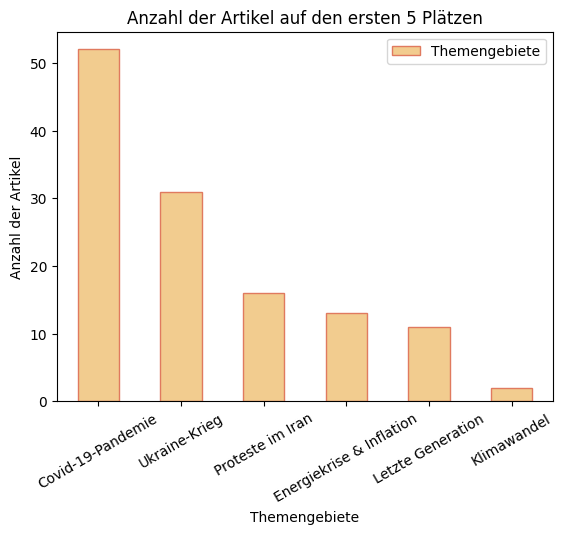

In [26]:
ax = df_topics.plot(kind="bar", x='topic', y='amount', xlabel="Themengebiete", ylabel="Anzahl der Artikel", color=["#f2cc8f"], legend=True, edgecolor=["#e07a5f"], rot=30)

ax.set_title('Anzahl der Artikel auf den ersten 5 Plätzen')
ax.legend(["Themengebiete"])

ax.get_figure().savefig('figures/bar-ranking-topic.png', bbox_inches="tight", dpi=float(dpi))